In [14]:
import numpy as np
import os
import urllib
import gzip
import struct
import matplotlib.pyplot as plt
import cv2
from skimage import io
# def download_data(url, force_download=True):     
#     fname = url.split("/")[-1]
#     if force_download or not os.path.exists(fname):
#         urllib.urlretrieve(url, fname)
#     return fname

# def read_data(label_url, image_url):
#     with gzip.open(download_data(label_url)) as flbl:
#         magic, num = struct.unpack(">II", flbl.read(8))
#         label = np.fromstring(flbl.read(), dtype=np.int8)
#     with gzip.open(download_data(image_url), 'rb') as fimg:
#         magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
#         image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
#     return (label, image)

# path='mnist_data/'
# (train_lbl, train_img) = read_data(
#     path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
# (val_lbl, val_img) = read_data(
#     path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

In [15]:
# config file
gpus = '0,1'
begin_epoch = 0
num_epoch = 10
resume = True
model_prefix = 'model/e2e'
#
batch_size = 100
lr_rate = 0.1
# dataset
train_set = 'data/ImageSets/train.txt'
val_set = 'data/ImageSets/val.txt'

In [16]:
def load_image_set_index(image_set_path):
    image_set_index_file = os.path.join(image_set_path)
    assert os.path.exists(image_set_index_file), 'Path does not exist: {}'.format(image_set_index_file)
    with open(image_set_index_file) as f:
        image_set_index = [x.strip().split(' ')[0] for x in f.readlines()]
    with open(image_set_index_file) as f:
        label = [int(x.strip().split(' ')[1]) for x in f.readlines()]
    label = np.ndarray(shape=(len(label),), dtype= int, buffer=np.array(label))
    return image_set_index, label

def load_image(image_set_index):
    images = np.zeros([len(image_set_index), 28, 28], dtype = np.int)
    for idx, img_path in enumerate(image_set_index):
        image_file = os.path.join('data/img/',img_path + '.png')
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        images[idx,:,:] = image
    images = np.ndarray(shape=(np.shape(images)), dtype = np.int, buffer=images)
    return images

[train_set_index, train_lbl] = load_image_set_index(train_set)    
train_img = load_image(train_set_index)
[val_set_index, val_lbl] = load_image_set_index(val_set)    
val_img = load_image(val_set_index)

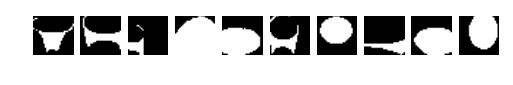

label: [1 1 1 1 1 1 1 1 1 1]


In [39]:
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()

print('label: %s' % (train_lbl[0:10],))

In [18]:
# config
gpus = '0,1'
begin_epoch = 0
num_epoch = 10
resume = False
model_prefix = 'model/e2e'


batch_size = 100
lr_rate = 0.1

In [19]:
import mxnet as mx

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)

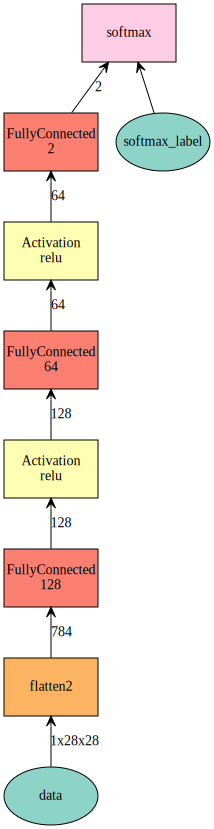

In [30]:
# Create a place holder variable for the input data
data = mx.sym.Variable('data')
# Flatten the data from 4-D shape (batch_size, num_channel, width, height) 
# into 2-D (batch_size, num_channel*width*height)
data = mx.sym.Flatten(data=data)

# The first fully-connected layer
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=128)
# Apply relu to the output of the first fully-connnected layer
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")

# The second fully-connected layer and the according activation function
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")

# The thrid fully-connected layer, note that the hidden size should be 10, which is the number of unique digits
fc3  = mx.sym.FullyConnected(data=act2, name='fc3', num_hidden=2)
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 1, 28, 28)}
# mx.viz.plot_network(symbol=mlp, shape=shape)

In [21]:
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
# create a trainable module on CPU
ctx = [mx.gpu(int(i)) for i in gpus.split(',')]
mlp_model = mx.mod.Module(symbol=mlp, context=ctx)
if resume:
    sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, num_epoch)
else:
    arg_params,aux_params = None,None
    
mlp_model.fit(train_iter,              # train data
              eval_data=val_iter,      # validation data
              optimizer='sgd',         # use SGD to train
              optimizer_params={'learning_rate':lr_rate},  # use fixed learning rate
              arg_params=arg_params, aux_params=aux_params,
              eval_metric='acc',                           # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 100), # output progress for each 100 data batches
              begin_epoch = begin_epoch, num_epoch=num_epoch)                # train for at most 10 dataset passes
mlp_model.save_checkpoint(model_prefix, num_epoch)

INFO:root:Epoch[0] Train-accuracy=0.660000
INFO:root:Epoch[0] Time cost=0.008
INFO:root:Epoch[0] Validation-accuracy=0.940000
INFO:root:Epoch[1] Train-accuracy=0.805000
INFO:root:Epoch[1] Time cost=0.007
INFO:root:Epoch[1] Validation-accuracy=0.940000
INFO:root:Epoch[2] Train-accuracy=0.805000
INFO:root:Epoch[2] Time cost=0.005
INFO:root:Epoch[2] Validation-accuracy=0.940000
INFO:root:Epoch[3] Train-accuracy=0.805000
INFO:root:Epoch[3] Time cost=0.005
INFO:root:Epoch[3] Validation-accuracy=0.940000
INFO:root:Epoch[4] Train-accuracy=0.805000
INFO:root:Epoch[4] Time cost=0.005
INFO:root:Epoch[4] Validation-accuracy=0.940000
INFO:root:Epoch[5] Train-accuracy=0.805000
INFO:root:Epoch[5] Time cost=0.005
INFO:root:Epoch[5] Validation-accuracy=0.940000
INFO:root:Epoch[6] Train-accuracy=0.805000
INFO:root:Epoch[6] Time cost=0.005
INFO:root:Epoch[6] Validation-accuracy=0.940000
INFO:root:Epoch[7] Train-accuracy=0.805000
INFO:root:Epoch[7] Time cost=0.005
INFO:root:Epoch[7] Validation-accuracy=0

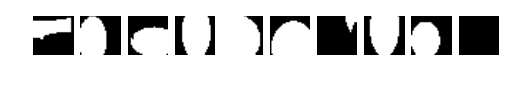

Predict label: [1 1 1 1 1 1 1 1 1 1]
Predict Prob : [ 0.74308312  0.74342656  0.74342561  0.74354941  0.74382472  0.7438876
  0.74229187  0.74355924  0.74340379  0.74192452]


In [47]:
prob = mlp_model.predict(val_iter)[0:10].asnumpy()
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(val_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('Predict label: %s' % (prob.argmax(axis=1)))
print('Predict Prob : %s' % (prob.max(axis=1)))
# assert max(prob) > 0.70, "Low prediction accuracy."

In [48]:
test_iter = mx.io.NDArrayIter(val_img, val_lbl, batch_size)
# predict accuracy of mlp
acc = mx.metric.Accuracy()
mlp_model.score(test_iter, acc)
print(acc)
assert acc.get()[1] > 0.60


EvalMetric: {'accuracy': 0.94}


In [ ]:
# reference
# https://github.com/dmlc/mxnet-notebooks/blob/master/python/tutorials/mnist.ipynb
# https://mxnet.incubator.apache.org/tutorials/python/mnist.html